In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries


In [2]:
df = pd.read_csv('../csv/Ming1Jul67_total_order.csv')
print(df.head())
print(df.tail())

  order_completed_at  unique_order_count
0         2023-01-01                  15
1         2023-01-02                  32
2         2023-01-03                  89
3         2023-01-04                  73
4         2023-01-05                  67
    order_completed_at  unique_order_count
543         2024-06-27                 145
544         2024-06-28                 142
545         2024-06-29                 126
546         2024-06-30                 161
547         2024-07-01                 142


In [3]:
df.shape

(548, 2)

In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

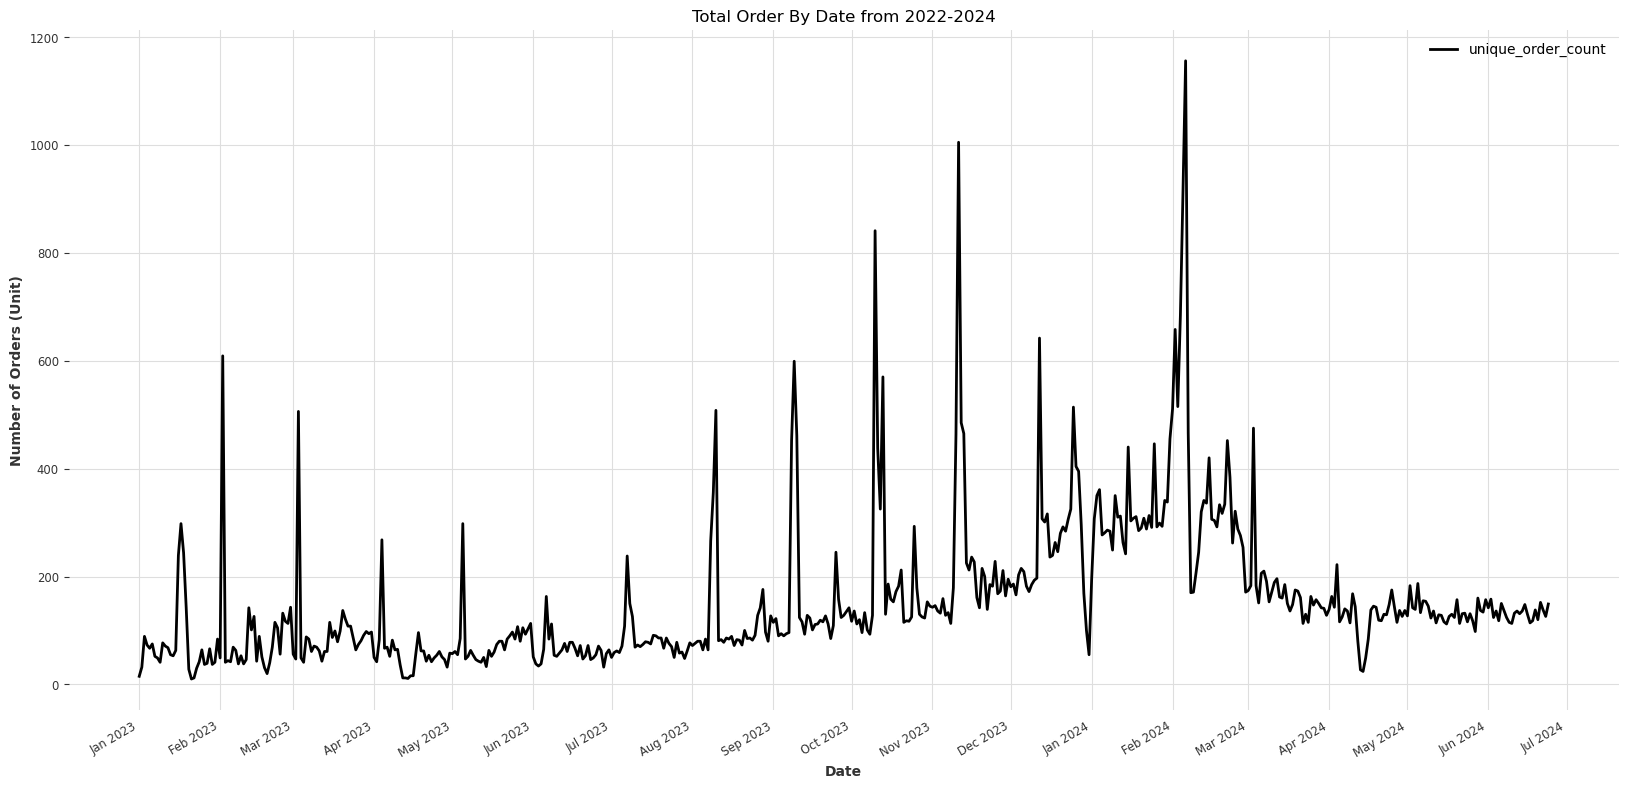

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10)) 
series.plot()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 

plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

# Feature Engineering

### remove outlier 

In [5]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier

C:\Users\User\AppData\Local\Temp\ipykernel_344\1351848665.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.51486988847583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [6]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series_rescaled = scaler.fit_transform(series)
series = series_rescaled

In [7]:
# training, validation =series.split_before(pd.Timestamp('2024-01-01'))
# training, validation =series.split_before(0.9)
cut_off = pd.Timestamp('2024-05-01')
training, validation =series.split_before(cut_off) # 1 month
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month

In [8]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(training_df.shape)
print(validation_df.shape)

component           unique_order_count
order_completed_at                    
2024-04-26                    0.265347
2024-04-27                    0.207921
2024-04-28                    0.251485
2024-04-29                    0.229703
2024-04-30                    0.251485
component           unique_order_count
order_completed_at                    
2024-05-01                    0.231683
2024-05-02                    0.342574
2024-05-03                    0.261386
2024-05-04                    0.255446
2024-05-05                    0.350495
(486, 1)
(62, 1)


### show data remove outlier

In [ ]:
# plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)

# ##prediction
# series.plot(label="data")
# # series_remove_outlier.plot(label="remove_outlier")

# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Order Unit')
# plt.show()

In [ ]:
# plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)

# ##prediction
# # series_remove_outlier.plot(label="remove_outlier")

# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Order Unit')
# plt.show()

In [9]:
# from darts.dataprocessing.transformers import (
#     Scaler,
# )

# scaler = Scaler()
# series = series_remove_outlier #!!!
# series_rescaled = scaler.fit_transform(series)

In [ ]:
# plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)

# ##prediction
# # series_rescaled.plot(label="data")

# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Order Unit')
# plt.show()

In [ ]:
# plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)

# ##prediction
# # original_data = scaler.inverse_transform(series_rescaled)
# # original_data.plot(label="data")

# plt.legend()
# plt.xlabel('Date')
# plt.ylabel('Order Unit')
# plt.show()

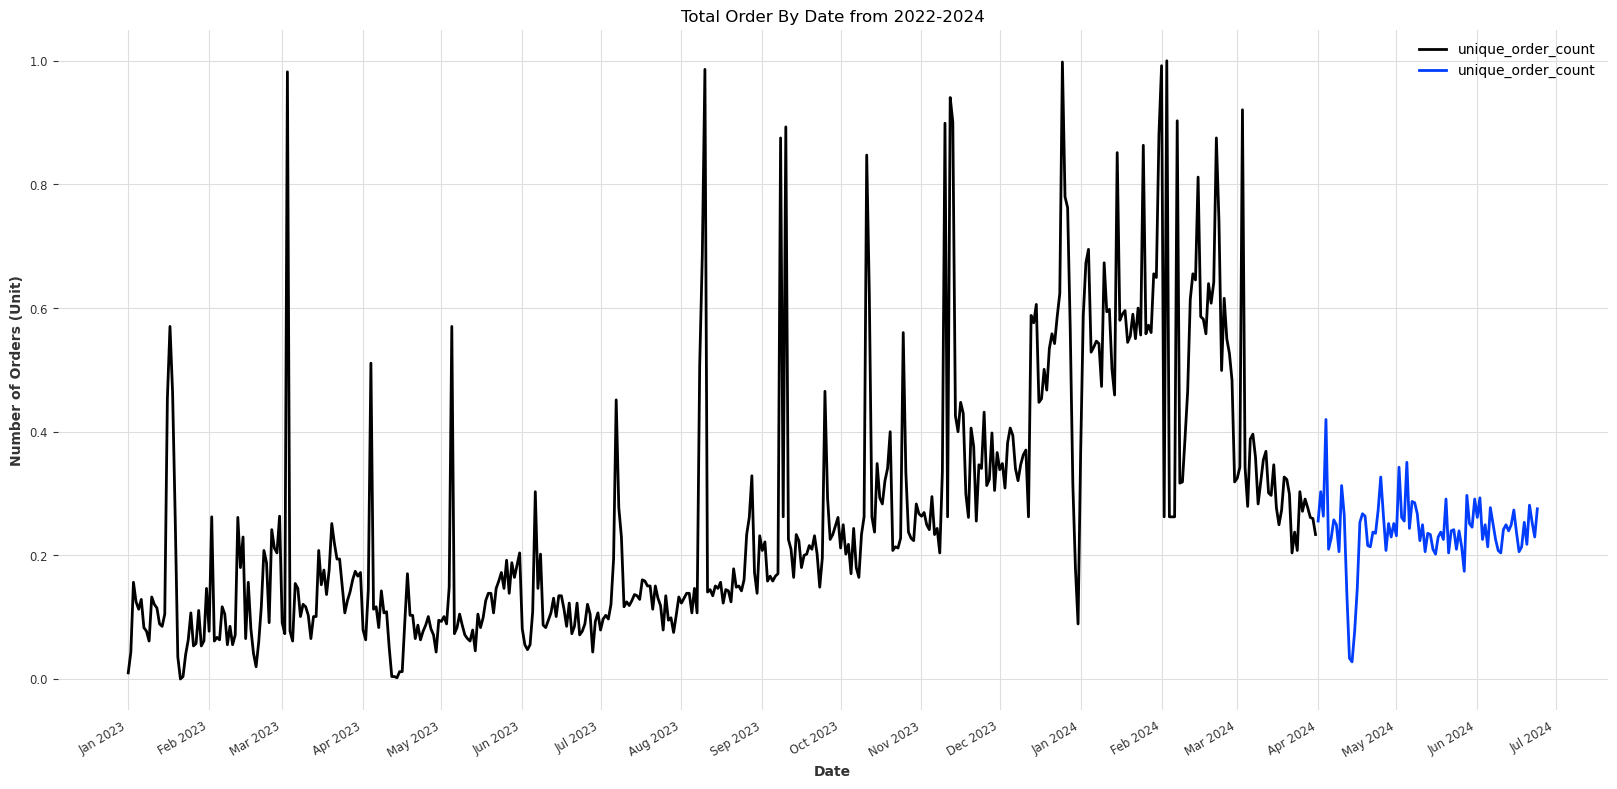

In [29]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [11]:
from darts.models import RandomForest

model = RandomForest(lags=26, output_chunk_length=7, n_estimators=100, max_depth=11,random_state=42) # must at least input lags
model.fit(training)
forecast = model.predict(len(validation))
best_model = model

In [ ]:
# plot Actual and Predict
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  
series.plot(label="Actual")
forecast.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [144]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
#not recommendation

mape_score = mape(validation, forecast)
print(f'score MAPE: {mape_score}')

mase_score = mase(validation, forecast, training)
print(f'score MASE: {mase_score}')

score MAPE: 16.974912339431366
score MASE: 0.4750104237927845


In [145]:
# historical forecast not found, only backtesting

backtest_errors = model.backtest(
     series,
     start=0.9,          # เริ่มต้นที่ 80% ของข้อมูล
     forecast_horizon=3, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=True,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่ , เพราะต้องการแค่ทำนายวันพรุ่งนี้
     metric=mape,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


In [146]:
print(f'backtest_errors MAPE: {round(backtest_errors,2)}%')

backtest_errors MAPE: 13.55%


In [20]:
# Making a parameter dictionary for use in the gridsearch function
# Gridsearch will return the best model that hasn't been trained yet.
from darts.models import RandomForest
from darts.metrics import mape, mae, mse, mase
from math import sqrt

parameters = {
    "lags": list(range(1,36)), 
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7,9,11],
    "output_chunk_length":[7],
    "random_state": [42]
}

best_parameter = RandomForest.gridsearch(
    parameters=parameters,
    series = series, #note (training + validation) X only training set!!!
    start=cut_off,
    forecast_horizon=7,
    stride=7,          
    last_points_only=False,  
    metric=mse,
    reduction=np.mean,
    verbose=-1
)

  0%|          | 0/525 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/15 [00:00<?, ?it/s]

In [21]:
print(best_parameter[0])
print(best_parameter[1])
print(f'MAPE: {best_parameter[2]}')
parameters_in = best_parameter[1].copy()

RandomForestRegressor(max_depth=11, random_state=42)
{'lags': 8, 'n_estimators': 100, 'max_depth': 11, 'output_chunk_length': 7, 'random_state': 42}
MAPE: 0.0057181207996738195


In [22]:
# best_model = best_parameter[0]
# fit best model
# best_model = RandomForest(
#     lags = 3,
#     n_estimators=200,
#     output_chunk_length=7,
#     max_depth=9,
#     random_state=42)
#     # random_state=42)

best_model = best_parameter[0]
best_model.fit(training)

RandomForest(lags=8, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=11, multi_models=True, use_static_covariates=True, random_state=42)

In [12]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 14.0372
score ACC: 85.9628
score MSE: 0.0016
score RMSE: 0.04
score MAE: 0.0328


In [13]:
validation_rescale = scaler.inverse_transform(validation)
prediction_rescale = scaler.inverse_transform(prediction)

mape_score = mape(validation_rescale, prediction_rescale)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation_rescale, prediction_rescale)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation_rescale, prediction_rescale)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 12.9216
score ACC: 87.0784
score MSE: 407.0859
score RMSE: 20.1764
score MAE: 16.5747


In [15]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = best_model.backtest(
     scaler.inverse_transform(series),
     start=0.8,          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MSE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors MSE: 1735.626089946788


In [16]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = best_model.backtest(
     series,
     start=0.8,          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mape,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MAPE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors MAPE: 42.75134537316368


In [71]:
# for out in out_lst: print(out)

In [17]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 73.1682
score ACC: 26.8318
score MSE: 0.0186
score RMSE: 0.1363
score MAE: 0.1238


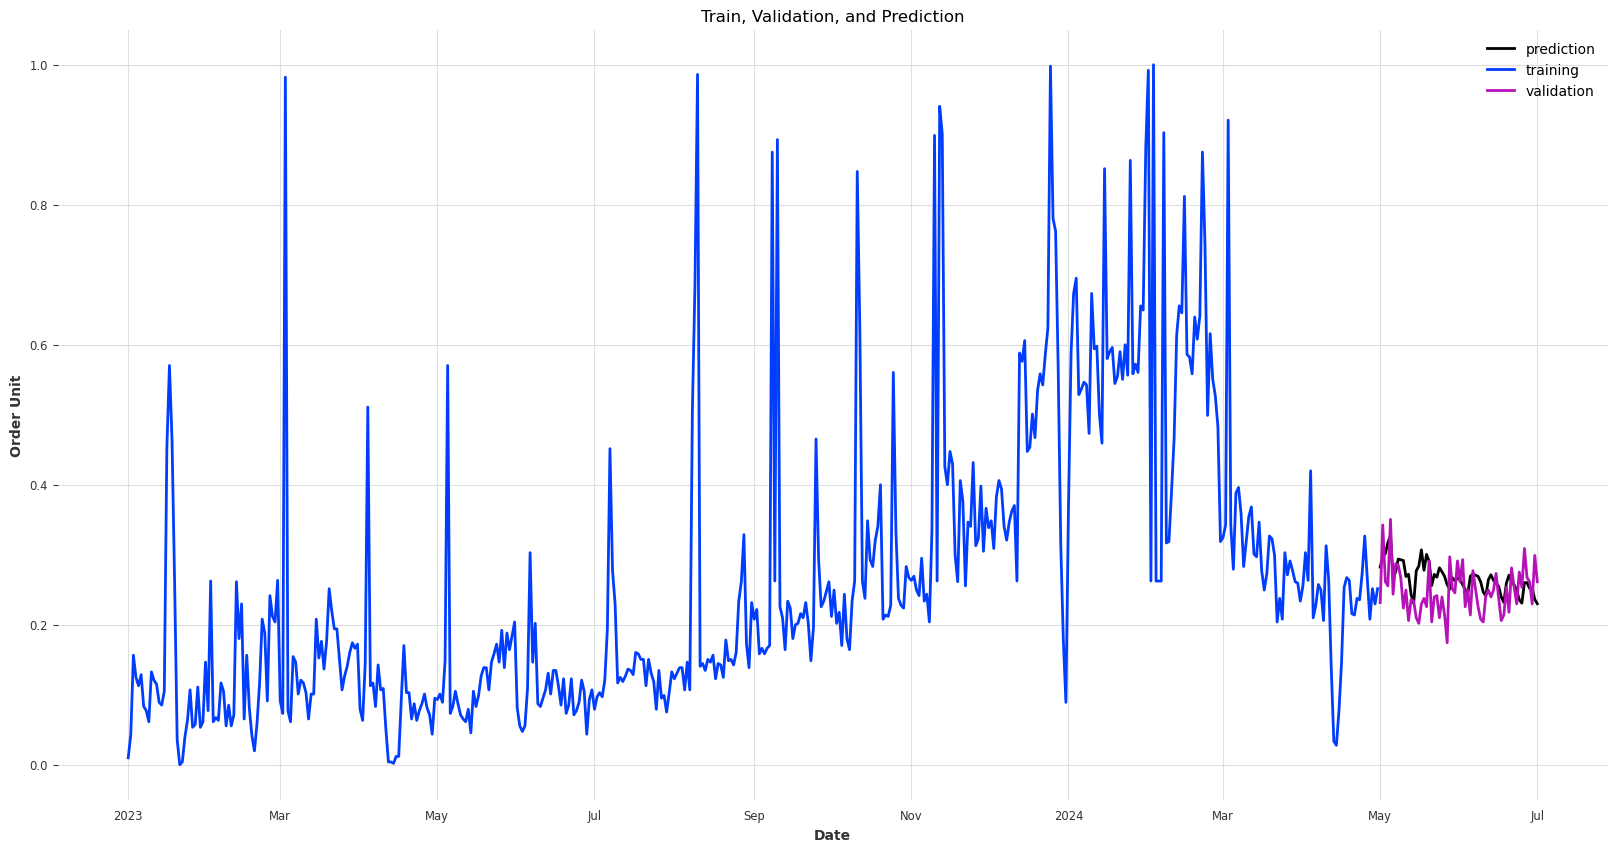

In [14]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [15]:
# predict future
best_model.fit(series)

RandomForest(lags=26, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=7, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=11, multi_models=True, use_static_covariates=True, random_state=42)

In [16]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-18,0.213861
2024-06-19,0.253465
2024-06-20,0.217822
2024-06-21,0.281188
2024-06-22,0.253465
2024-06-23,0.229703
2024-06-24,0.275248
2024-06-25,0.253465
2024-06-26,0.308911


In [17]:
forecast = best_model.predict(7)
forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.tail(7).to_csv('../forecast/Date_RandomForest_1month.csv', index=False)

        Date  Total Order
0 2024-07-02   138.886172
1 2024-07-03   138.451837
2 2024-07-04   137.975258
3 2024-07-05   136.150446
4 2024-07-06   135.187693
5 2024-07-07   134.825503
6 2024-07-08   135.123250


In [36]:
# forecast.to_csv('../forecast/19-25-06-67_RandomForest.csv', index=False)

In [18]:
best_model.save("../model/RandomForestModel_totalOrder_1Jul67.pkl")

In [5]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.models import RandomForest

training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

best_model = RandomForest.load("../model/RandomForestModel_totalOrder_25Jun67.pkl")
backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MSE: {backtest_errors}')

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


backtest_errors MSE: 303.6846435406512
